# データ可視化の学術的な発展

## 準備

In [54]:
# warningsモジュールのインポート
import warnings

# データ解析や機械学習のライブラリ使用時の警告を非表示にする目的で警告を無視
# 本書の文脈では、可視化の学習に議論を集中させるために選択した
# ただし、学習以外の場面で、警告を無視する設定は推奨しない
warnings.filterwarnings("ignore")

In [55]:
#!pip install japanize_matplotlib

In [104]:
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [57]:
# 入出力ディレクトリの定義

# マンガデータの読み込み先
DIR_IN = Path("../../../data/cm/input")

# マンガ各話データ名
FN_CE = "cm_ce.csv"

# マンガ作品とマンガ作者の対応データ
FN_CC_CRT = "cm_cc_crt.csv"

## 複雑なデータ構造への対応

In [114]:
df_ce = pd.read_csv(DIR_IN / FN_CE)
df_cc_crt = pd.read_csv(DIR_IN / FN_CC_CRT)

In [196]:
df_jump = df_ce[df_ce["mcname"] == "週刊少年ジャンプ"]

In [200]:
# ccname数
df_jump["ccname"].nunique()

2110

In [201]:
n = 15
ccnames = df_jump.groupby("ccname").size().nlargest(n).index.tolist()
df_jump_top = df_jump[df_jump["ccname"].isin(ccnames)].reset_index(drop=True)

In [202]:
pairs = df_jump_top.groupby("miid")["ccname"].apply(lambda x: list(x)).tolist()

In [203]:
edge_weights = {}
for pair in pairs:
    for i in range(len(pair)):
        for j in range(i + 1, len(pair)):
            cc1, cc2 = sorted([pair[i], pair[j]])
            edge_weights[(cc1, cc2)] = edge_weights.get((cc1, cc2), 0) + 1

In [204]:
edge_weights

{('こちら葛飾区亀有公園前派出所', 'キン肉マン'): 400,
 ('キャプテン翼', 'キン肉マン'): 303,
 ('こちら葛飾区亀有公園前派出所', 'キャプテン翼'): 363,
 ('ONE PIECE', 'トリコ'): 368,
 ('NARUTO-ナルト-', 'ONE PIECE'): 678,
 ('ONE PIECE', '家庭教師ヒットマンREBORN!'): 393,
 ('ONE PIECE', '銀魂'): 598,
 ('BLEACH', 'ONE PIECE'): 666,
 ('ONE PIECE', 'こちら葛飾区亀有公園前派出所'): 883,
 ('NARUTO-ナルト-', 'トリコ'): 323,
 ('トリコ', '家庭教師ヒットマンREBORN!'): 231,
 ('トリコ', '銀魂'): 412,
 ('BLEACH', 'トリコ'): 392,
 ('こちら葛飾区亀有公園前派出所', 'トリコ'): 419,
 ('NARUTO-ナルト-', '家庭教師ヒットマンREBORN!'): 415,
 ('NARUTO-ナルト-', '銀魂'): 534,
 ('BLEACH', 'NARUTO-ナルト-'): 635,
 ('NARUTO-ナルト-', 'こちら葛飾区亀有公園前派出所'): 741,
 ('家庭教師ヒットマンREBORN!', '銀魂'): 420,
 ('BLEACH', '家庭教師ヒットマンREBORN!'): 420,
 ('こちら葛飾区亀有公園前派出所', '家庭教師ヒットマンREBORN!'): 432,
 ('BLEACH', '銀魂'): 608,
 ('こちら葛飾区亀有公園前派出所', '銀魂'): 639,
 ('BLEACH', 'BLEACH'): 15,
 ('BLEACH', 'こちら葛飾区亀有公園前派出所'): 737,
 ('NARUTO-ナルト-', 'NARUTO-ナルト-'): 13,
 ('トリコ', 'トリコ'): 10,
 ('ONE PIECE', 'ONE PIECE'): 22,
 ('家庭教師ヒットマンREBORN!', '家庭教師ヒットマンREBORN!'): 10,
 ('銀魂', '銀魂'): 11,
 ('こちら葛飾区亀有公園前派出

In [205]:
# e. NetworkXグラフ作成
G = nx.Graph()
for cc in ccnames:
    G.add_node(cc)

for (cc1, cc2), weight in edge_weights.items():
    G.add_edge(cc1, cc2, weight=weight)

pos = nx.spring_layout(G, k=0.5)

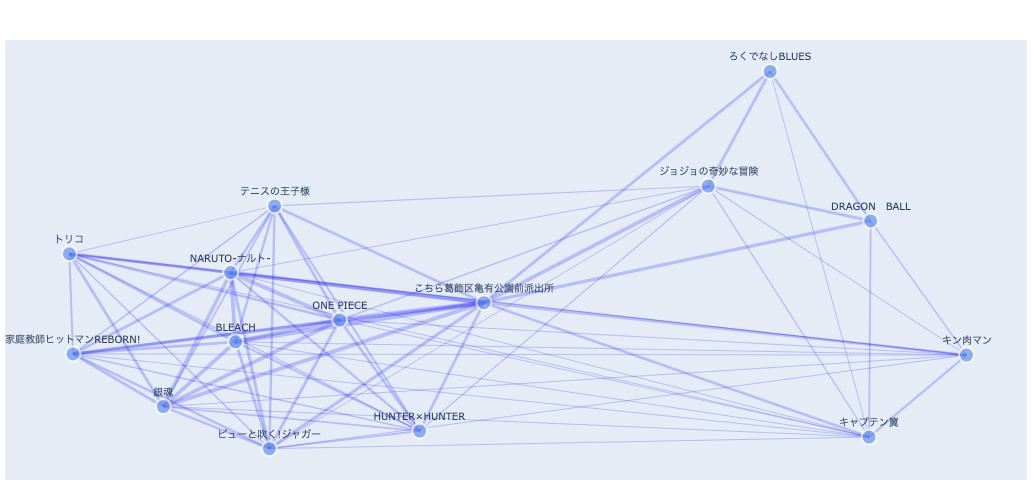

In [206]:
# エッジの重みを取得
weights = [G.edges[e]["weight"] for e in G.edges]

# 重みを正規化
scaler = MinMaxScaler(feature_range=(1.0, 5.0))  # 最小幅1.0、最大幅5.0に設定
normalized_edge_weights = scaler.fit_transform(
    np.array(weights).reshape(-1, 1)
).flatten()

# エッジトレースのリストを作成
edge_traces = []

# エッジの位置と幅を設定
for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        mode="lines",
        opacity=0.2,
        line=dict(width=normalized_edge_weights[i], color="blue"),
        hoverinfo="none",
    )
    edge_traces.append(edge_trace)

# ノードを作成
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode="markers",
    hoverinfo="text",
    marker=dict(color=[], size=[], line_width=2),
    textposition="top center",
    textfont=dict(size=10),
)

# ノードの位置とサイズを設定
for node in G.nodes():
    x, y = pos[node]
    node_trace["x"] += tuple([x])
    node_trace["y"] += tuple([y])
    node_trace["marker"]["color"] += tuple(["cornflowerblue"])
    node_trace["marker"]["size"] += tuple([15])
    node_trace["text"] += tuple([node])

# アノテーションを作成
annotations = [
    dict(
        x=pos[node][0],
        y=pos[node][1],
        xref="x",
        yref="y",
        text=node,
        showarrow=False,
        font=dict(size=10),
        align="center",
        yshift=15,  # ノードの上にテキストを配置
    )
    for node in G.nodes()
]

# レイアウトを設定
layout = go.Layout(
    title="",
    titlefont_size=16,
    showlegend=False,
    hovermode="closest",
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=annotations,
    height=500,
)

# figureを作成
fig = go.Figure(data=edge_traces + [node_trace], layout=layout)

# プロット
fig.show()

In [208]:
n = 500
ccnames = df_jump.groupby("ccname").size().nlargest(n).index.tolist()
df_jump_top = df_jump[df_jump["ccname"].isin(ccnames)].reset_index(drop=True)

In [209]:
pairs = df_jump_top.groupby("miid")["ccname"].apply(lambda x: list(x)).tolist()

In [210]:
edge_weights = {}
for pair in pairs:
    for i in range(len(pair)):
        for j in range(i + 1, len(pair)):
            cc1, cc2 = sorted([pair[i], pair[j]])
            edge_weights[(cc1, cc2)] = edge_weights.get((cc1, cc2), 0) + 1

In [211]:
# e. NetworkXグラフ作成
G = nx.Graph()
for cc in ccnames:
    G.add_node(cc)

for (cc1, cc2), weight in edge_weights.items():
    G.add_edge(cc1, cc2, weight=weight)

pos = nx.spring_layout(G, k=0.5)

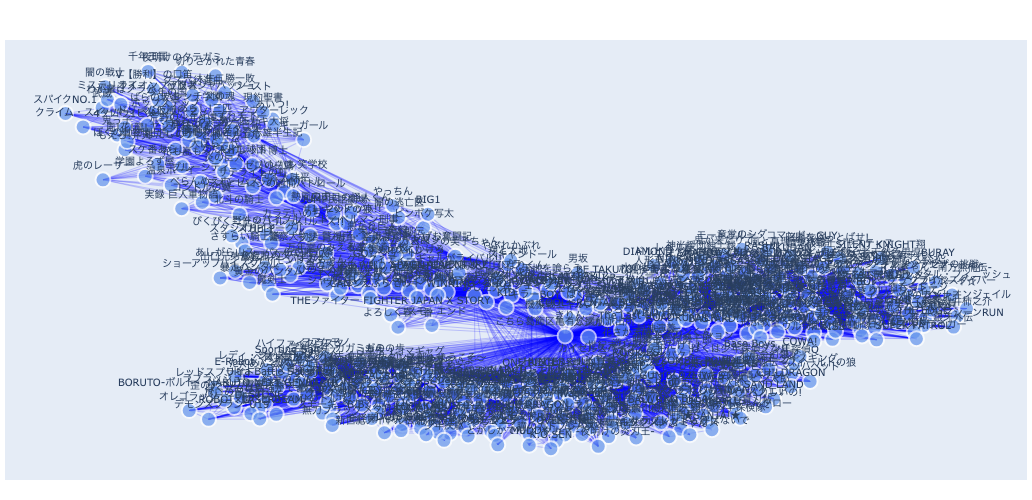

In [212]:
# エッジの重みを取得
weights = [G.edges[e]["weight"] for e in G.edges]

# 重みを正規化
scaler = MinMaxScaler(feature_range=(1.0, 5.0))  # 最小幅1.0、最大幅5.0に設定
normalized_edge_weights = scaler.fit_transform(
    np.array(weights).reshape(-1, 1)
).flatten()

# エッジトレースのリストを作成
edge_traces = []

# エッジの位置と幅を設定
for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        mode="lines",
        opacity=0.2,
        line=dict(width=normalized_edge_weights[i], color="blue"),
        hoverinfo="none",
    )
    edge_traces.append(edge_trace)

# ノードを作成
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode="markers",
    hoverinfo="text",
    marker=dict(color=[], size=[], line_width=2),
    textposition="top center",
    textfont=dict(size=10),
)

# ノードの位置とサイズを設定
for node in G.nodes():
    x, y = pos[node]
    node_trace["x"] += tuple([x])
    node_trace["y"] += tuple([y])
    node_trace["marker"]["color"] += tuple(["cornflowerblue"])
    node_trace["marker"]["size"] += tuple([15])
    node_trace["text"] += tuple([node])

# アノテーションを作成
annotations = [
    dict(
        x=pos[node][0],
        y=pos[node][1],
        xref="x",
        yref="y",
        text=node,
        showarrow=False,
        font=dict(size=10),
        align="center",
        yshift=15,  # ノードの上にテキストを配置
    )
    for node in G.nodes()
]

# レイアウトを設定
layout = go.Layout(
    title="",
    titlefont_size=16,
    showlegend=False,
    hovermode="closest",
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=annotations,
    height=500,
)

# figureを作成
fig = go.Figure(data=edge_traces + [node_trace], layout=layout)

# プロット
fig.show()